Eksik değerlerin yeniden kontrolü:
0


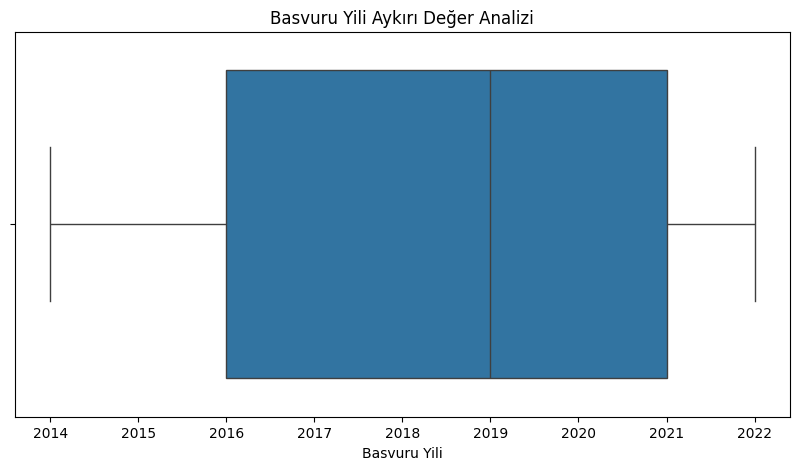

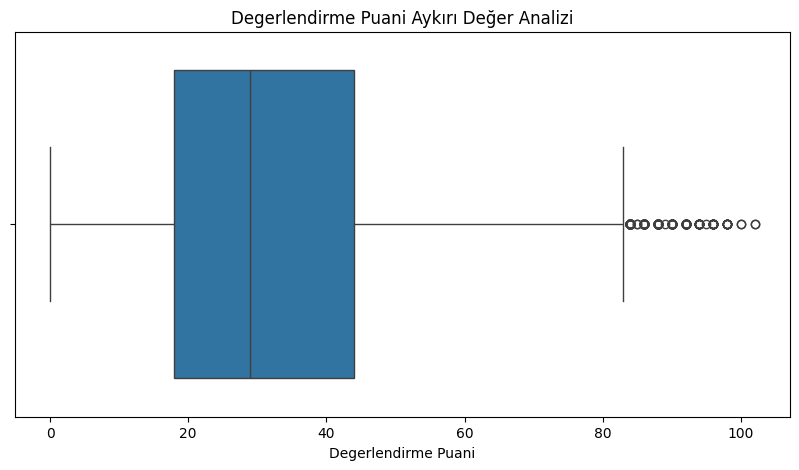

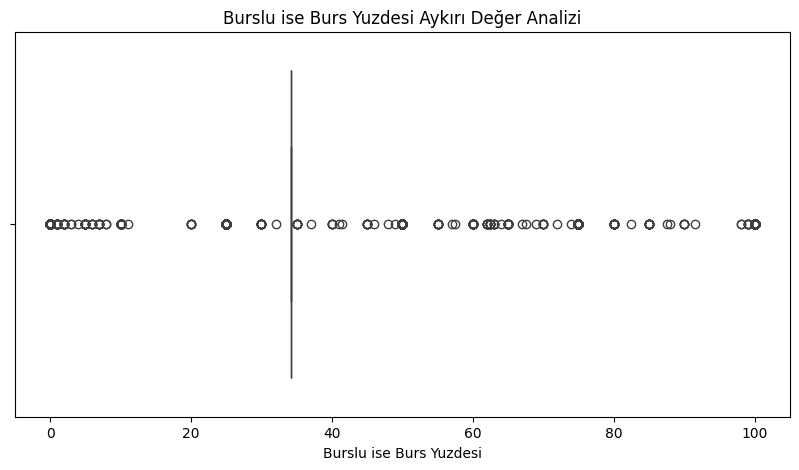

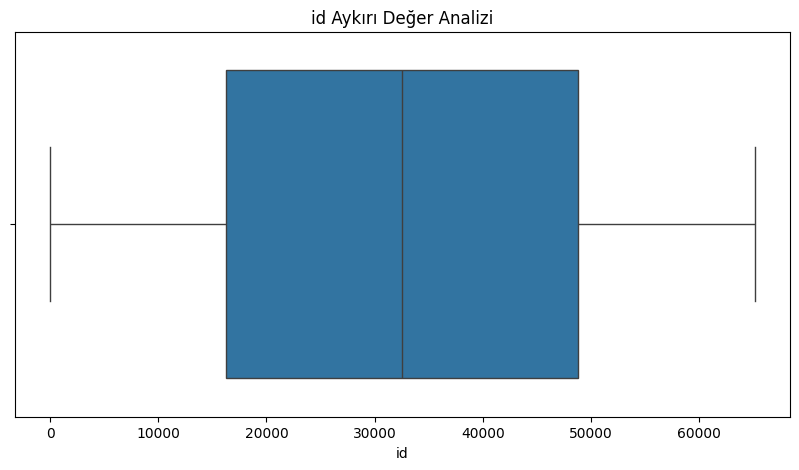

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Dosyaları yükle
train_df = pd.read_csv(r"C:\Users\Admin\Desktop\train.csv", low_memory=False)
test_df = pd.read_csv(r"C:\Users\Admin\Desktop\test_x.csv", low_memory=False)
submission_sample = pd.read_csv(r"C:\Users\Admin\Desktop\sample_submission.csv", low_memory=False)

# 2. Eksik değerlerin analizi ve doldurulması
# Kategorik ve sayısal sütunları ayıralım
categorical_cols = train_df.select_dtypes(include=['object']).columns
numerical_cols = train_df.select_dtypes(exclude=['object']).columns

# Sayısal sütunlardaki eksik değerleri ortalama ile dolduralım
imputer_num = SimpleImputer(strategy='mean')
train_df[numerical_cols] = imputer_num.fit_transform(train_df[numerical_cols])

# Kategorik sütunlardaki eksik değerleri en sık görülen değer (mod) ile dolduralım
imputer_cat = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols] = imputer_cat.fit_transform(train_df[categorical_cols])

# Kategorik sütunları sayısal değerlere dönüştürelim
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    label_encoders[col] = le

# Eksik verileri tamamladıktan sonra, yeniden kontrol edelim
print("Eksik değerlerin yeniden kontrolü:")
print(train_df.isnull().sum().sum())  # Sıfır olmalıdır

# 3. Aykırı değerlerin analizi ve filtrelenmesi
for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=train_df[col])
    plt.title(f'{col} Aykırı Değer Analizi')
    plt.show()

# IQR ile aykırı değerleri filtreleme
for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]

# 4. Hedef ve özellikleri belirleyelim
X = train_df.drop(columns=['Degerlendirme Puani'])
y = train_df['Degerlendirme Puani']

# Eğitim ve doğrulama setlerine ayıralım
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Hiperparametre optimizasyonu yapalım
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5 katlı çapraz doğrulama
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)

# En iyi parametreleri bulalım
best_params = grid_search.best_params_
print("En iyi parametreler:", best_params)

# 6. En iyi parametrelerle modelimizi yeniden eğitelim
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Doğrulama setinde tahmin yapalım
y_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("\nHiperparametre optimizasyonu sonrası Validation RMSE:", rmse)

# 7. Test verisi üzerinde tahmin yapalım
# Test verisini de aynı şekilde işlememiz gerekiyor
test_df[categorical_cols] = imputer_cat.transform(test_df[categorical_cols])
test_df[numerical_cols] = imputer_num.transform(test_df[numerical_cols])

# Test verisini encode edelim
for col in categorical_cols:
    test_df[col] = label_encoders[col].transform(test_df[col].astype(str))

# Test verisi üzerinde tahmin yap
test_predictions = best_model.predict(test_df)

# 8. Submission dosyasını oluşturalım
submission = pd.DataFrame({
    'id': test_df['id'],  # Test verisindeki ID'leri kullan
    'Degerlendirme Puani': test_predictions
})

submission.to_csv(r"C:\Users\Admin\Desktop\submission.csv", index=False)
print("Submission dosyası oluşturuldu.")

# 9. Exploratory Data Analysis (EDA)

# Hedef değişkenin dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Degerlendirme Puani Dağılımı')
plt.xlabel('Degerlendirme Puani')
plt.ylabel('Frekans')
plt.show()

# Korelasyon matrisi
plt.figure(figsize=(12, 10))
corr = train_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.show()

# Sayısal sütunların dağılımı
for col in numerical_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(train_df[col], kde=True)
    plt.title(f'{col} Dağılımı')
    plt.xlabel(col)
    plt.ylabel('Frekans')
    plt.show()

# 10. Model Performansını Görselleştirme

# Gerçek vs Tahmin Edilen Değerler
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.title('Gerçek vs Tahmin Edilen Degerlendirme Puani')
plt.xlabel('Gerçek Degerlendirme Puani')
plt.ylabel('Tahmin Edilen Degerlendirme Puani')
plt.show()

# Hata dağılımı (residuals)
residuals = y_valid - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Hata Dağılımı (Gerçek - Tahmin)')
plt.xlabel('Hata Değeri')
plt.ylabel('Frekans')
plt.show()

# 11. Modelin Önemli Özelliklerini İnceleme

# Özellik önemlerini alalım
importances = best_model.feature_importances_
features = X.columns

# Özellik önemlerini bir DataFrame'e dönüştürelim
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Görselleştirelim
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Özellik Önemleri')
plt.show()